In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!mv kaggle\ \(1\).json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
!unzip cifake-real-and-ai-generated-synthetic-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/REAL/4500 (10).jpg  
  inflating: train/REAL/4500 (2).jpg  
  inflating: train/REAL/4500 (3).jpg  
  inflating: train/REAL/4500 (4).jpg  
  inflating: train/REAL/4500 (5).jpg  
  inflating: train/REAL/4500 (6).jpg  
  inflating: train/REAL/4500 (7).jpg  
  inflating: train/REAL/4500 (8).jpg  
  inflating: train/REAL/4500 (9).jpg  
  inflating: train/REAL/4500.jpg     
  inflating: train/REAL/4501 (10).jpg  
  inflating: train/REAL/4501 (2).jpg  
  inflating: train/REAL/4501 (3).jpg  
  inflating: train/REAL/4501 (4).jpg  
  inflating: train/REAL/4501 (5).jpg  
  inflating: train/REAL/4501 (6).jpg  
  inflating: train/REAL/4501 (7).jpg  
  inflating: train/REAL/4501 (8).jpg  
  inflating: train/REAL/4501 (9).jpg  
  inflating: train/REAL/4501.jpg     
  inflating: train/REAL/4502 (10).jpg  
  inflating: train/REAL/4502 (2).jpg  
  inflating: train/REAL/4502 (3).jpg  
  inflating: train/REAL/4502 (4).jpg  
  inflating:

Found 100000 files belonging to 2 classes.


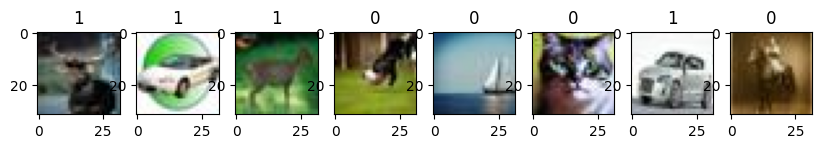

In [10]:
data = tf.keras.utils.image_dataset_from_directory('/content/train', image_size=(32, 32))
data_it = data.as_numpy_iterator()
batch = data_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [11]:
data = data.map(lambda x, y : (x/255, y))

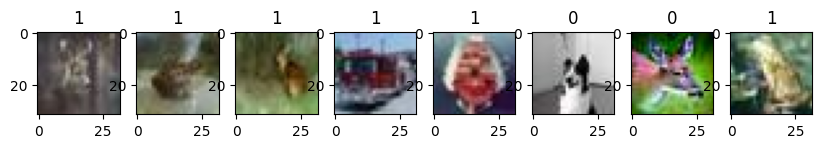

In [12]:
scaled_it = data.as_numpy_iterator()
batch = scaled_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])

In [13]:
train_size = int(len(data) * 0.7)
cv_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1) + 1

train = data.take(train_size)
cv = data.skip(train_size).take(cv_size)
test = data.skip(train_size + cv_size).take(test_size)

print("Train: ",len(train))
print("Test: ", len(test))
print("Val: ",len(cv))

Train:  2187
Test:  313
Val:  625


In [14]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,146,305 (92.11 MB)

 Trainable params: 24,092,673 (91.91 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [16]:
initial_learning_rate = 0.001
def lr_scheduler(epoch, lr):
    return lr * 0.95
lr_schedule = LearningRateScheduler(lr_scheduler)
optimizer = Adam(learning_rate=initial_learning_rate)

# Compiling the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
def augment_data(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x, max_delta=0.1)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)
    return x, y
train_augmented = data.map(augment_data)

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_augmented, validation_data=cv, epochs=10, callbacks=[lr_schedule, early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 178s 38ms/step - accuracy: 0.8287 - loss: 0.3985 - val_accuracy: 0.9062 - val_loss: 0.2366 - learning_rate: 9.5000e-04
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 115s 36ms/step - accuracy: 0.9086 - loss: 0.2293 - val_accuracy: 0.9153 - val_loss: 0.2128 - learning_rate: 9.0250e-04
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 119s 38ms/step - accuracy: 0.9252 - loss: 0.1965 - val_accuracy: 0.8726 - val_loss: 3.2560 - learning_rate: 8.5737e-04
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 136s 36ms/step - accuracy: 0.9331 - loss: 0.1738 - val_accuracy: 0.8859 - val_loss: 0.2728 - learning_rate: 8.1451e-04
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 142s 36ms/step - accuracy: 0.9269 - loss: 0.1854 - val_accuracy: 0.8005 - val_loss: 0.5888 - learning_rate: 7.7378e-04
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9133 - loss: 0.2118
Test Accuracy: 91.87%


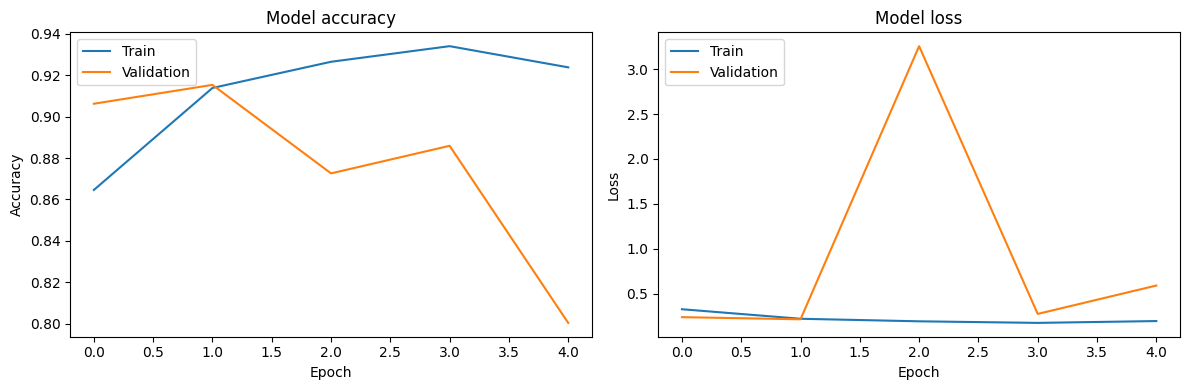

In [19]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [20]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

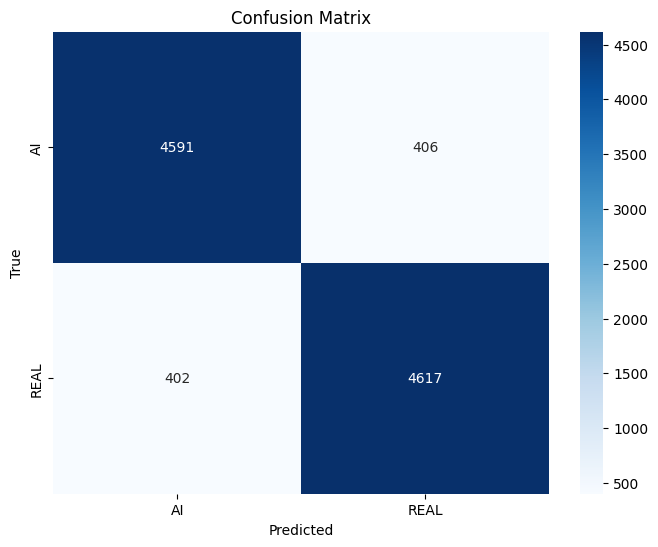

Classification Report:
               precision    recall  f1-score   support

          AI       0.92      0.92      0.92      4997
        REAL       0.92      0.92      0.92      5019

    accuracy                           0.92     10016
   macro avg       0.92      0.92      0.92     10016
weighted avg       0.92      0.92      0.92     10016



In [21]:
y_true = []
y_pred_probs = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_true.extend(y)
    y_pred_probs.extend(model.predict(X).flatten())

# Convert probabilities to binary predictions
y_pred = np.array(y_pred_probs) > 0.5

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=['AI', 'REAL'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'REAL'], yticklabels=['AI', 'REAL'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display Classification Report
print("Classification Report:\n", class_report)